# 🧠 YOLO Object Detection: Mineral Water Bottles


This notebook walks you through building a YOLO object detection model that identifies two types of mineral water bottles. We'll go step by step from data collection and labeling to training, evaluation, and deployment. The notebook is written with enough explanation so even non-technical users can understand how the process works.

##💻 Working in Google Colab
Colab gives you access to a virtual machine right in your browser, equipped with a Linux operating system, a full Python environment, and—best of all—a free GPU. In this environment, we'll install PyTorch and Ultralytics and use them to train our model. To run any section of code in this notebook, simply click the Play button next to it, and the code will execute on the virtual machine.

## 🔧 Step 1: Check for GPU (NVIDIA)

#Verify NVIDIA GPU Availability

Make sure you're using a GPU-equipped machine by going to "Runtime" -> "Change runtime type" in the top menu bar, and then selecting one of the GPU options in the Hardware accelerator section and the command checks if an NVIDIA GPU is available in the current Colab session. GPU (Graphics Processing Unit) accelerates deep learning model training significantly by handling matrix operations in parallel. For a model like YOLO that processes high-resolution images and learns complex patterns, having a GPU cuts down training time from hours to minutes. If no GPU is available, training will happen on CPU, which is much slower.

In [ ]:
!nvidia-smi

Fri May 16 18:17:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## ✍️ Data Collection & Labeling

The dataset contains images of mineral water bottles. These images were manually labeled using [Label Studio](https://labelstud.io/) using the "Object Detection" template. Each bottle was surrounded with a bounding box and labeled as either **bottle 1** or **bottle 2**.

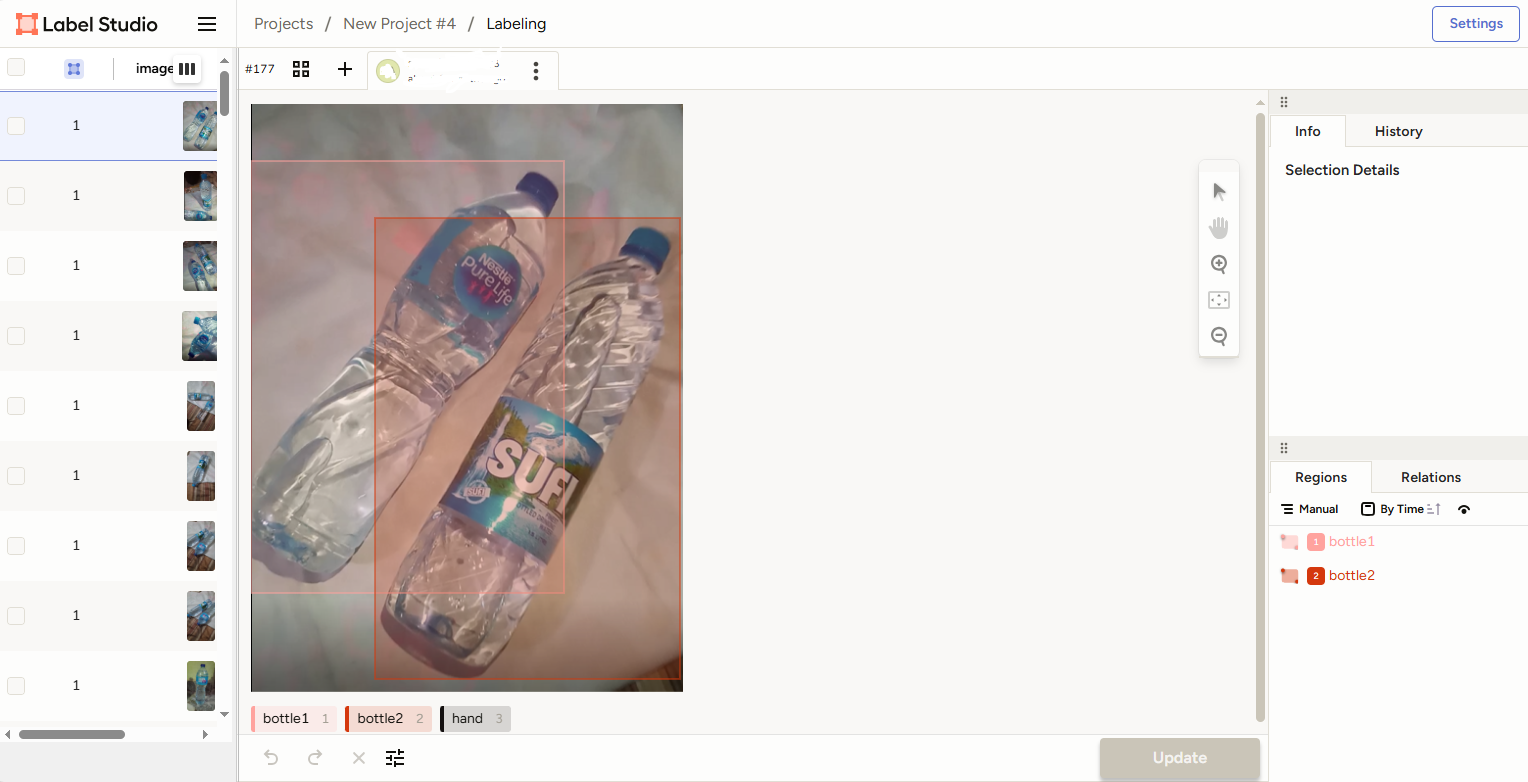
<i>Example of a bottles image labeled with Label Studio.</i>


Bounding boxes help the model learn where an object is in an image. Label Studio outputs the data in YOLO format, which stores each object's class and coordinates relative to the image size.

Export the images, they'll be exported in a project.zip file that contains the following:

An images folder containing the images
A labels folder containing the labels in YOLO annotation format
A classes.txt labelmap file that contains all the classes
A notes.json file that contains info specific to Label Studio (this file can be ignored)
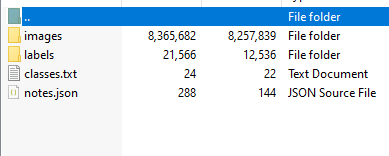

## 📂 Upload Labeled Data

**Option 1. Upload through Google Colab**

Upload the `data.zip` file to the Google Colab instance by clicking the "Files" icon on the left hand side of the browser, and then the "Upload to session storage" icon. Select the zip folder to upload it.

<p>
<br>
<img src="https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/doc/upload-colab-files.png" height="240">
</p>


**Option 2. Copy from Google Drive**

You can also upload your images to your personal Google Drive, mount the drive on this Colab session, and copy them over to the Colab filesystem. This option works well if you want to upload the images beforehand so you don't have to wait for them to upload each time you restart this Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/MyDrive/path/to/data.zip /content


## 🔄 Step 2: Split Data into Train and Validation Sets

At this point, you will see your data.zip file in the list of files. Next, we'll unzip data.zip and create some folders to hold the images. Run the following code block to unzip the data.

In [ ]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

Ultralytics requires a specific folder structure for organizing training data used in model development. The root directory should be named "data", and within it, there are two primary subfolders:
* **Train**: This folder contains the images used to train the model. During each training epoch, all images in this set are fed into the neural network, allowing the training algorithm to adjust the model’s weights based on the input data.
* **Validation**: This folder holds images used to evaluate the model's performance after each epoch, helping monitor how well the model is learning.
Each of these subfolders—Train and Validation—must include two additional folders:

images: Contains the image files.

labels: Contains the corresponding annotation files for each image.

I created a Python script that automatically sets up the required folder structure and randomly splits the dataset—moving 90% of the files to the "train" folder and the remaining 10% to the "validation" folder. Simply run the code block below to download and execute the script.

In [ ]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-05-16 18:18:01--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-05-16 18:18:01 (55.1 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 136
Number of annotation files: 136
Images moving to train: 122
Images moving to validation: 14


## 📦 Step 3: Install Ultralytics YOLO Library
Install the Ultralytics library in this Google Colab environment. This Python library is essential for training the YOLO model.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

## ⚙️ Step 4: Configure Training

Before we can start training, there's one final step: creating the Ultralytics training configuration YAML file. This file defines the paths to your training and validation data, as well as the list of model classes.

Run the code block below to automatically generate a data.yaml file. Ensure that a label map file exists at custom_data/classes.txt. If you used Label Studio or one of the provided datasets, this file should already be in place. If you created your dataset differently, you might need to manually create the classes.txt file.

In [ ]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 3
names:
- bottle1
- bottle2
- hand



**Explanation**: The `data.yaml` file defines the training configuration:
- `"nc"` is the number of classes (3: bottle 1 , bottle 2 and hand)
- `"names"` lists the class labels
- `"train"` and `"val"` point to image folders

This file tells YOLO what it's learning and where to find the data. Without it, training won't start.


## 🏋️ Step 5: Train the Model
Now that the data is properly organized and the configuration file is set up, we’re ready to begin training! Before starting, there are a few key parameters to consider:
**Model Architecture & Size (model)**
YOLO11 offers several model sizes to choose from, including yolo11n.pt, yolo11s.pt, yolo11m.pt, yolo11l.pt, and yolo11xl.pt.
* Smaller models (like yolo11n.pt) train and run faster but are generally less accurate.
* Larger models (like yolo11xl.pt) provide better accuracy but require more time and computational power.
If you're unsure which to choose, yolo11s.pt is a solid starting point.
You can also use YOLOv8 or YOLOv5 by replacing yolo11 with yolov8 or yolov5 in the model name.

**Number of Epochs (epochs)**
An epoch is one full pass through the training dataset. The number of epochs determines how long the model will train.
* For smaller datasets (fewer than 200 images): Start with around 60 epochs.
* For larger datasets (more than 200 images): 40 epochs is a good starting point.
These values can be adjusted later based on performance.

**Image Resolution (imgsz)**
Image resolution significantly affects both training speed and model accuracy.
* 640x640 is the standard resolution for most YOLO models.
* If you need faster inference or are working with lower-resolution images, you can reduce the size (e.g., 480x480) to speed up training, though this may slightly reduce accuracy.

## 5.2 Run Training!
Run the code block below to start training. If you'd like to use a different model, adjust the model parameter. To change the training duration or image resolution, modify the epochs and imgsz values accordingly.

In [ ]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 18.4M/18.4M [00:00<00:00, 373MB/s]
Ultralytics 8.3.137 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, i

The training algorithm will process the images in the training and validation folders and begin training the model. After each epoch, the model is evaluated on the validation set, and metrics such as mAP (mean Average Precision), precision, and recall are reported. As training progresses, you should generally see an improvement in the mAP score. Training will continue until the specified number of epochs is completed.

**Important**: Let the training run all the way to the end—an optimizer step runs at the conclusion to remove unnecessary layers and finalize the model.

The best-performing model weights will be saved at:
content/runs/detect/train/weights/best.pt

Additional training details, including performance plots (e.g., results.png showing the progression of loss, precision, recall, and mAP), can be found in the directory:
content/runs/detect/train

## 🔍 Step 6: Test the Trained Model
The model has been trained—now it's time to put it to the test! The commands below will run the model on the images in the validation folder and display the results for the first 10 images. This is a great way to verify that your model is functioning correctly. Click "Play" on the blocks below to see how it performs.

In [ ]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.137 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

image 1/14 /content/data/validation/images/01e32f8c-ezgif-frame-050.jpg: 640x384 1 bottle2, 1 hand, 48.0ms
image 2/14 /content/data/validation/images/09302acc-ezgif-frame-070.jpg: 640x384 1 bottle1, 1 bottle2, 1 hand, 10.8ms
image 3/14 /content/data/validation/images/0e7ead0f-ezgif-frame-128.jpg: 640x384 1 bottle2, 1 hand, 10.8ms
image 4/14 /content/data/validation/images/0ff855b9-img_134.jpg: 640x384 1 bottle1, 1 bottle2, 10.8ms
image 5/14 /content/data/validation/images/130699c2-img_19.jpg: 640x384 1 bottle2, 10.8ms
image 6/14 /content/data/validation/images/1a8d946d-img_130.jpg: 640x384 1 bottle1, 10.8ms
image 7/14 /content/data/validation/images/2f66bf2e-img_96.jpg: 640x384 1 bottle1, 1 bottle2, 1 hand, 10.8ms
image 8/14 /content/data/validation/images/4e5aaaac-img_122.jpg: 640x384 1 bottle1, 1 bottle2, 10.8ms
image 

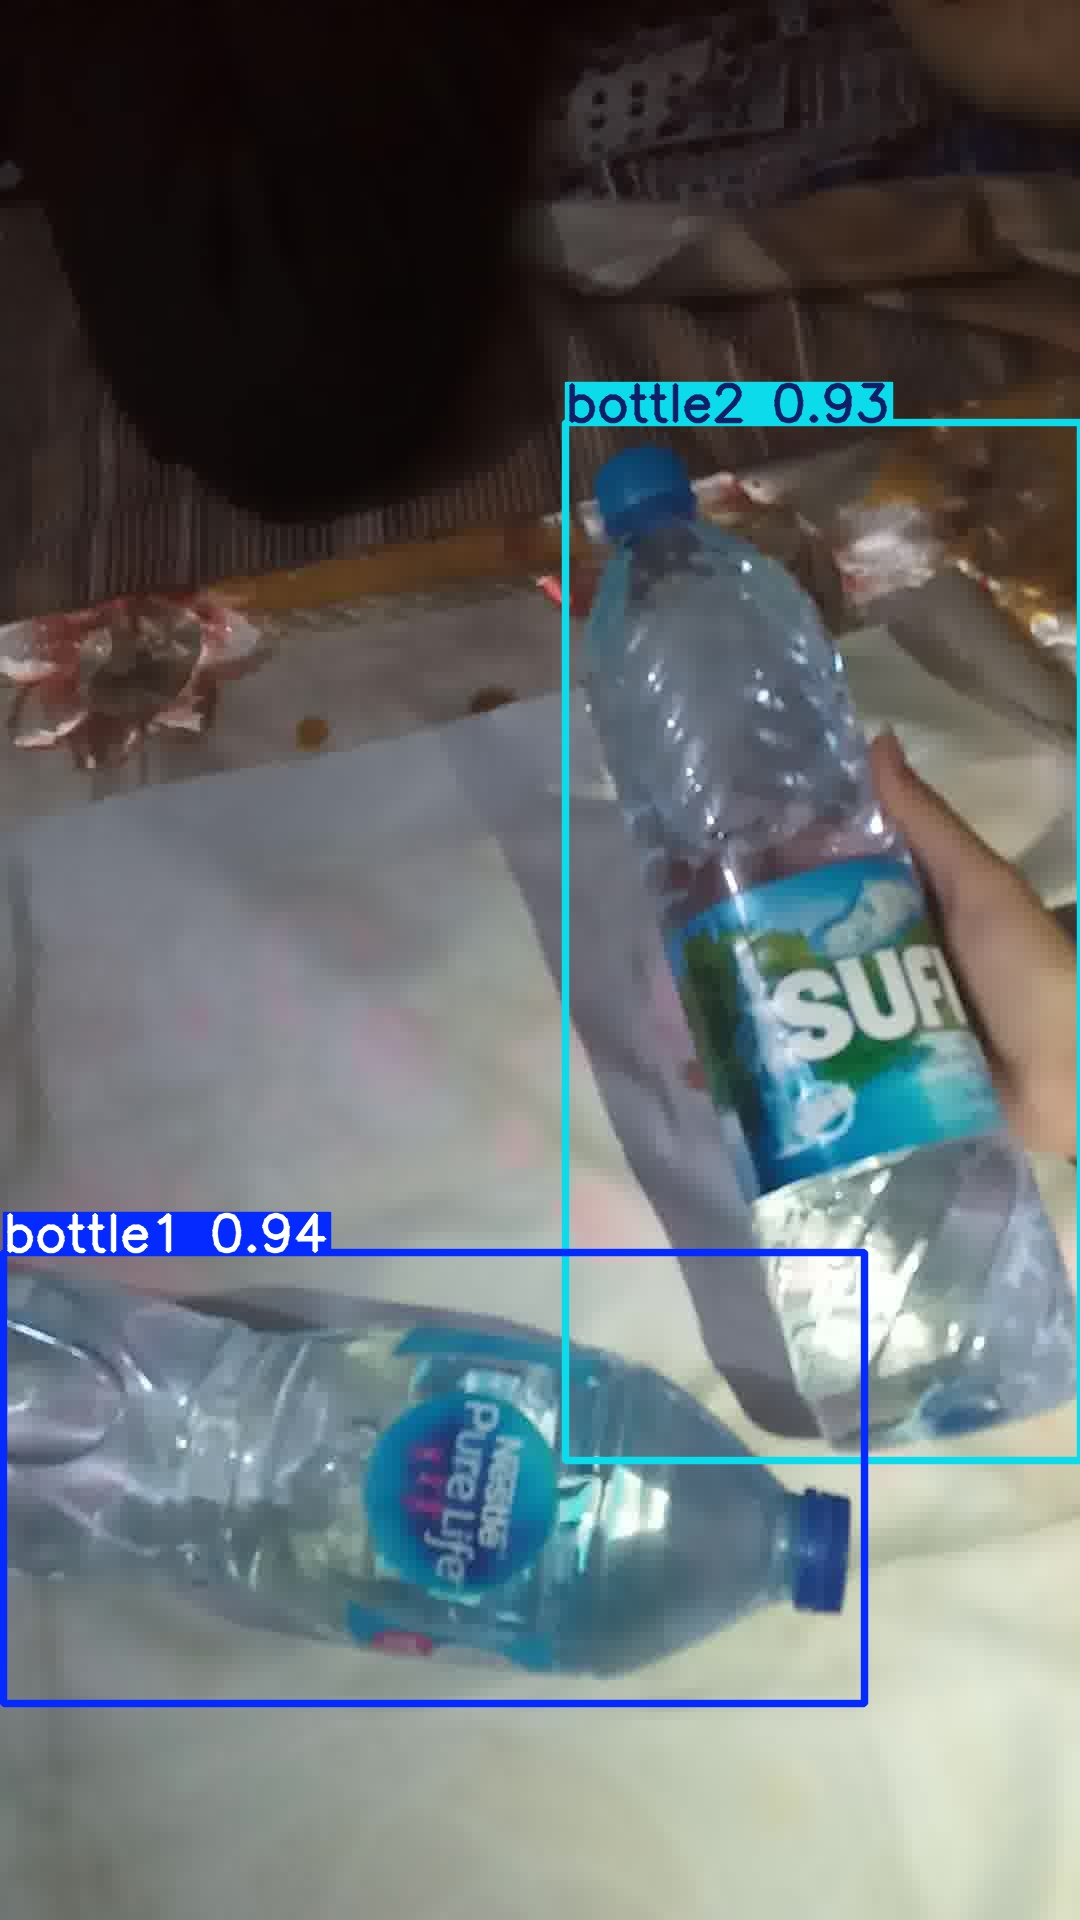

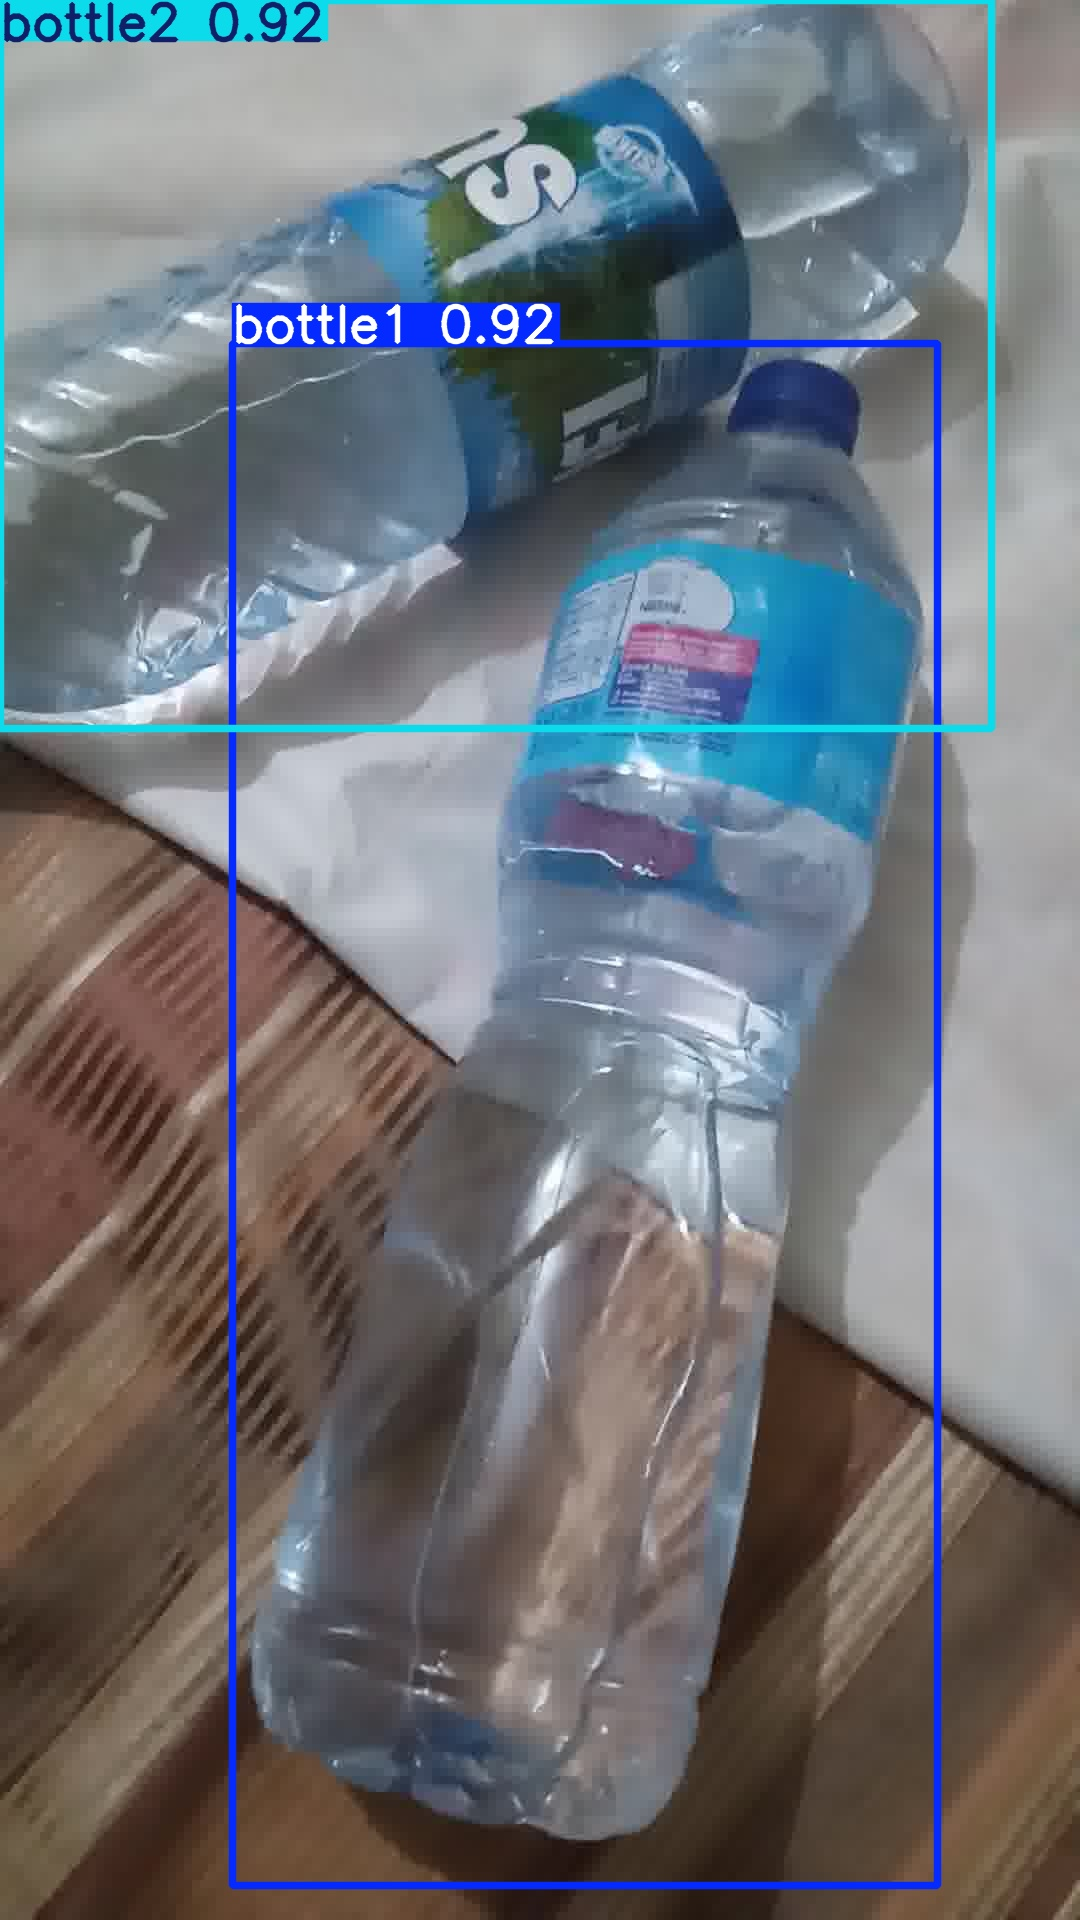

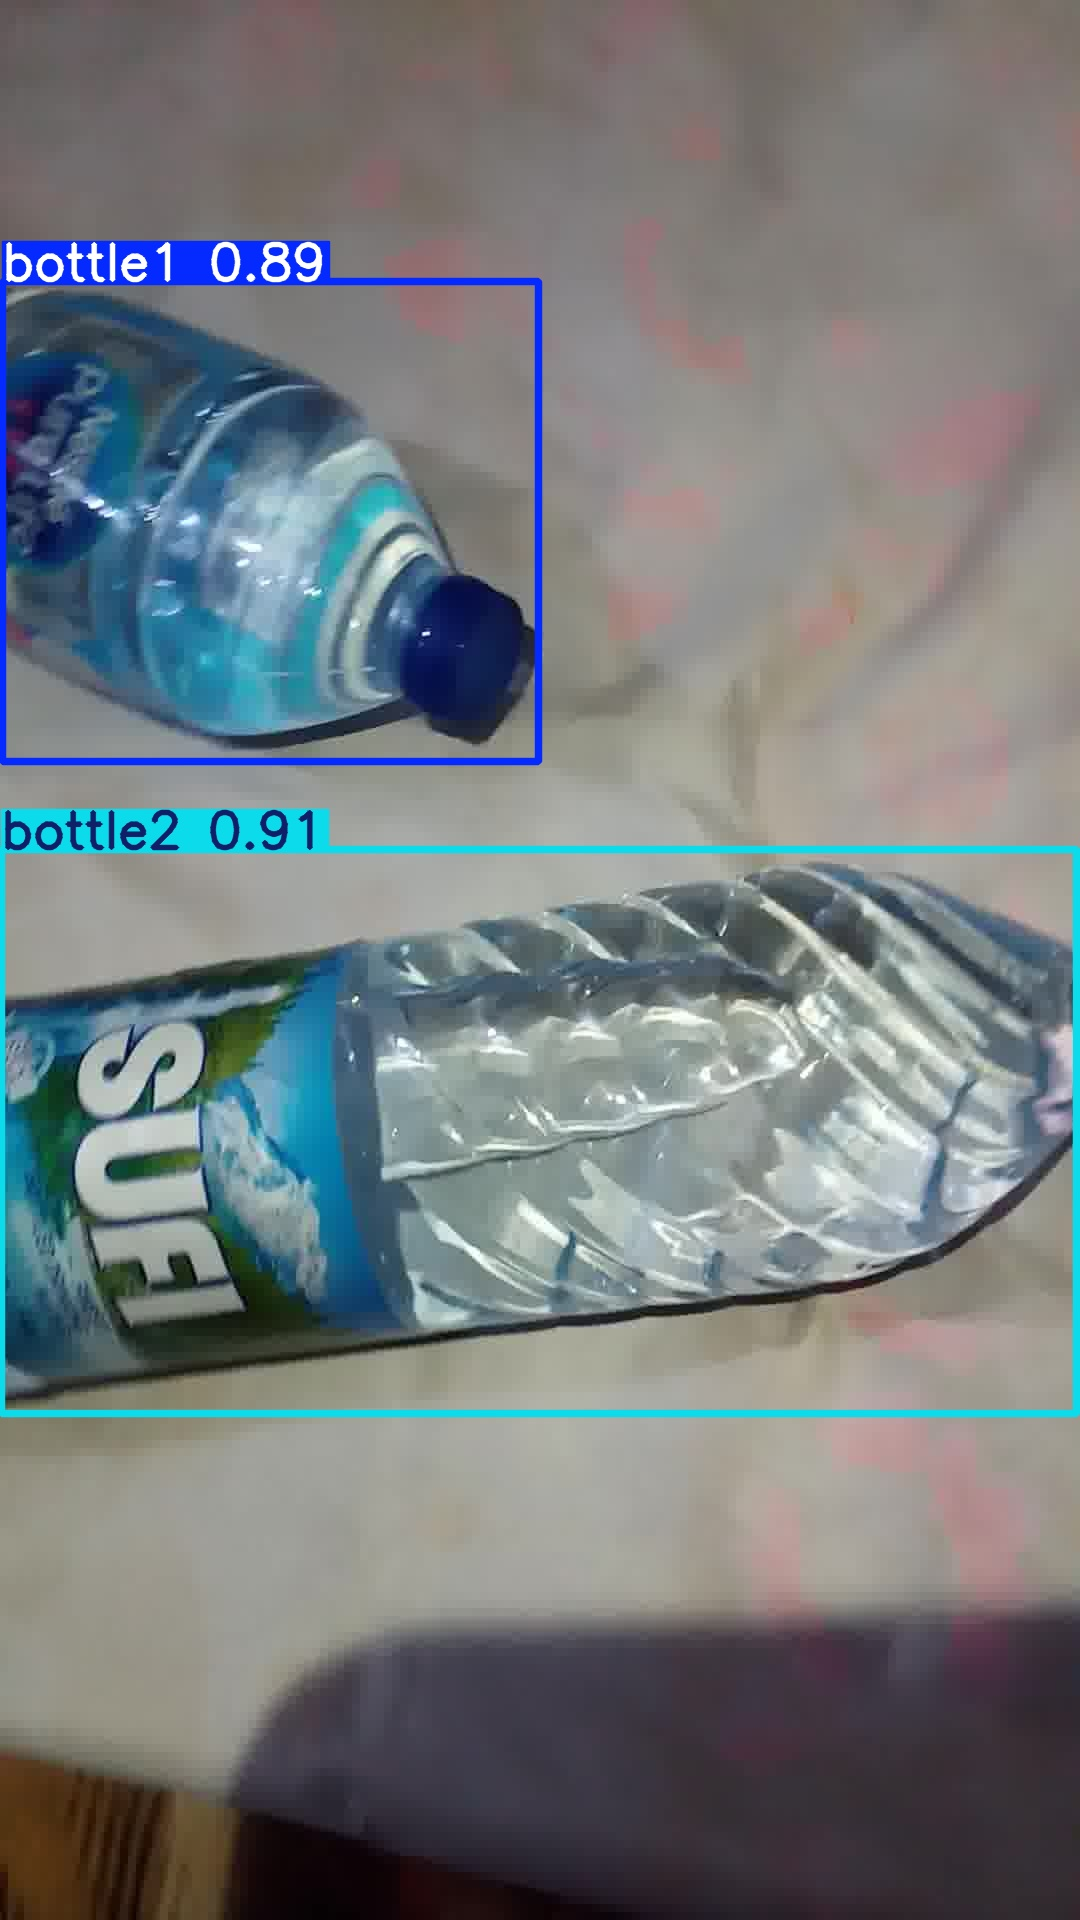

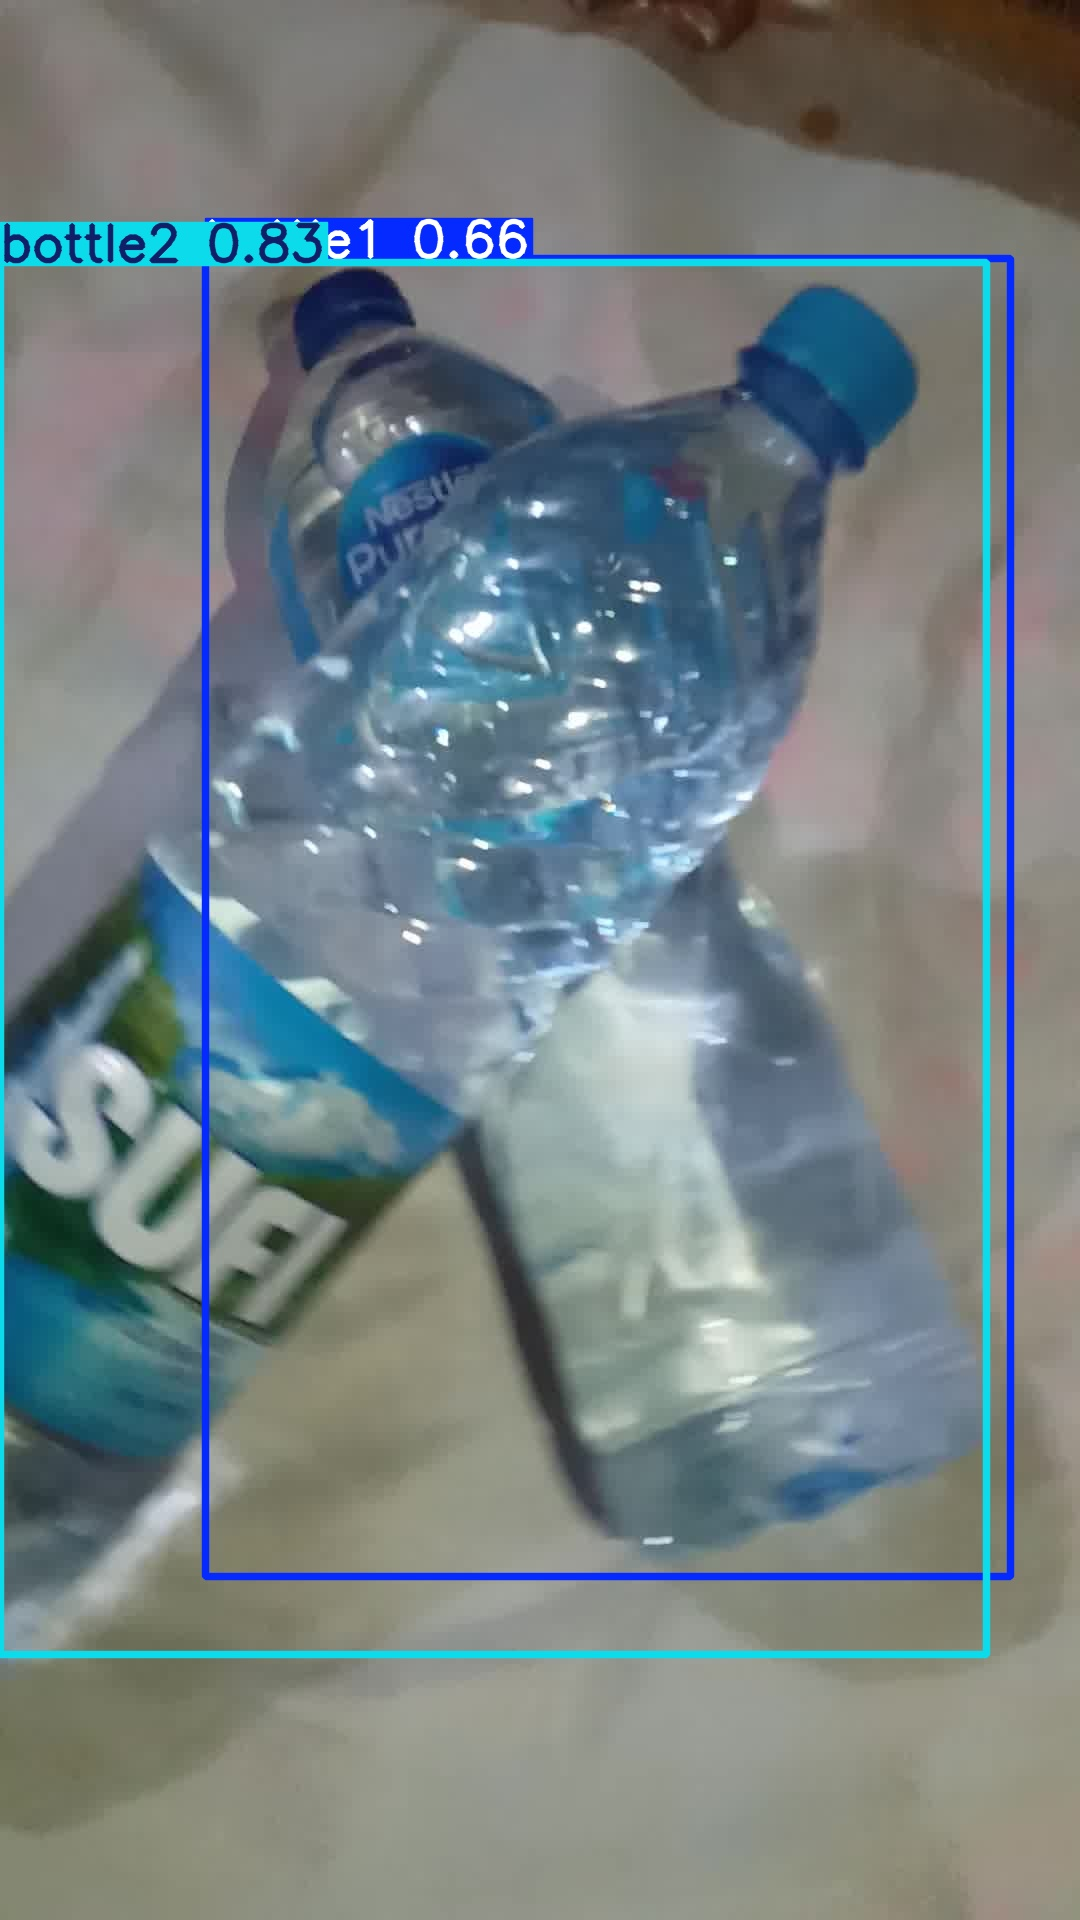

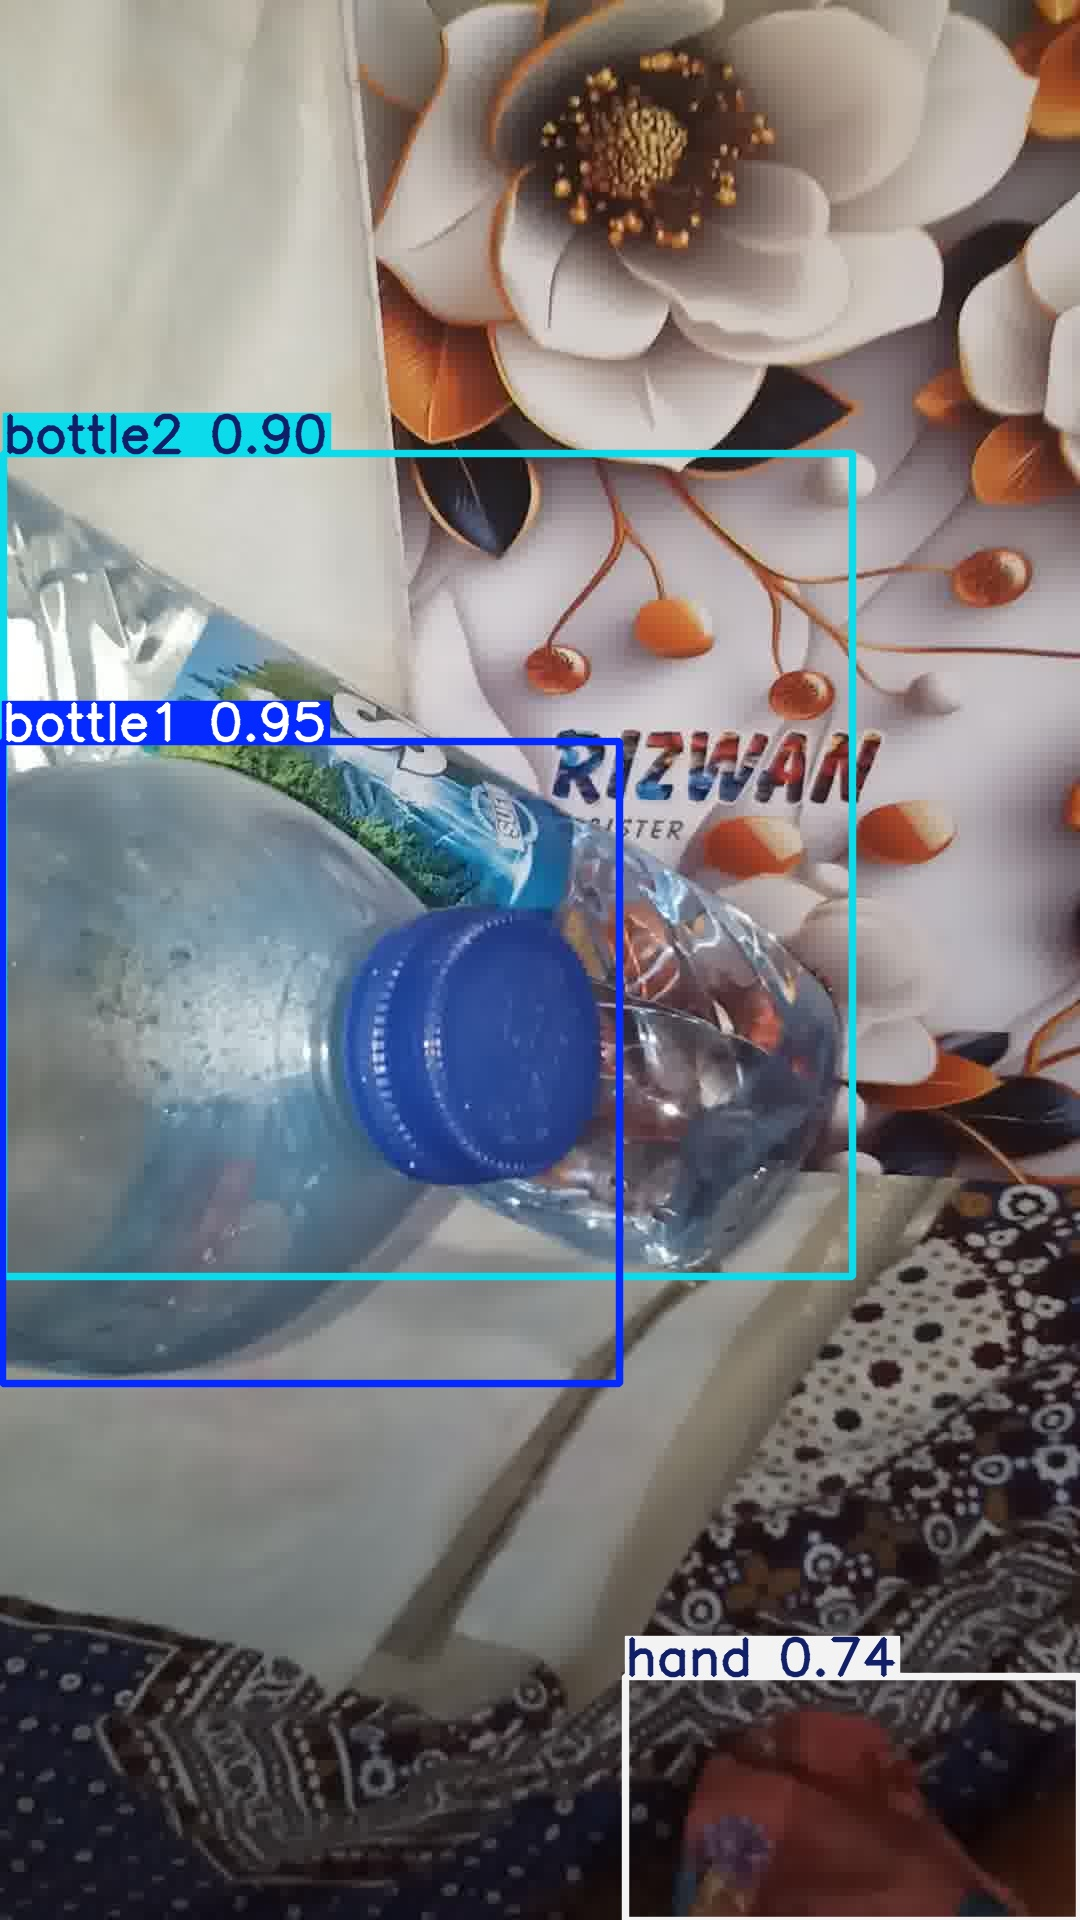

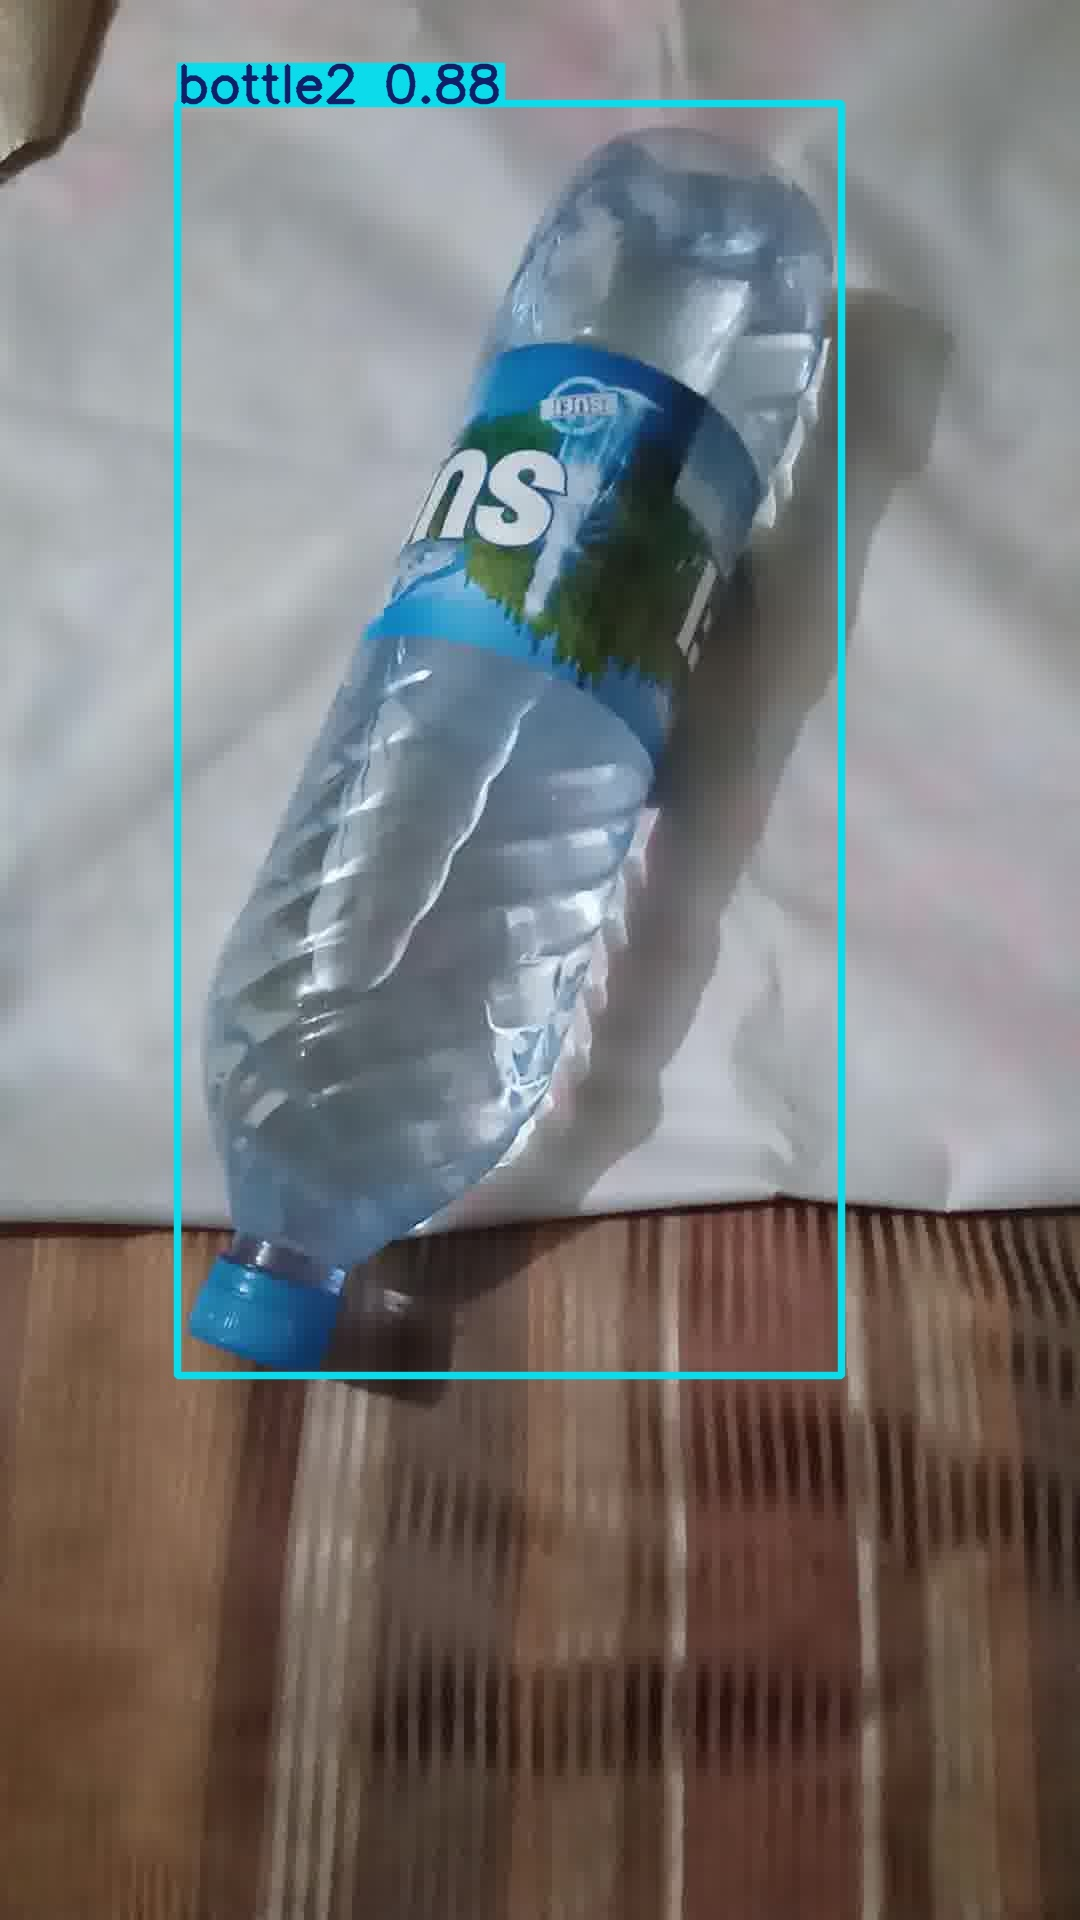

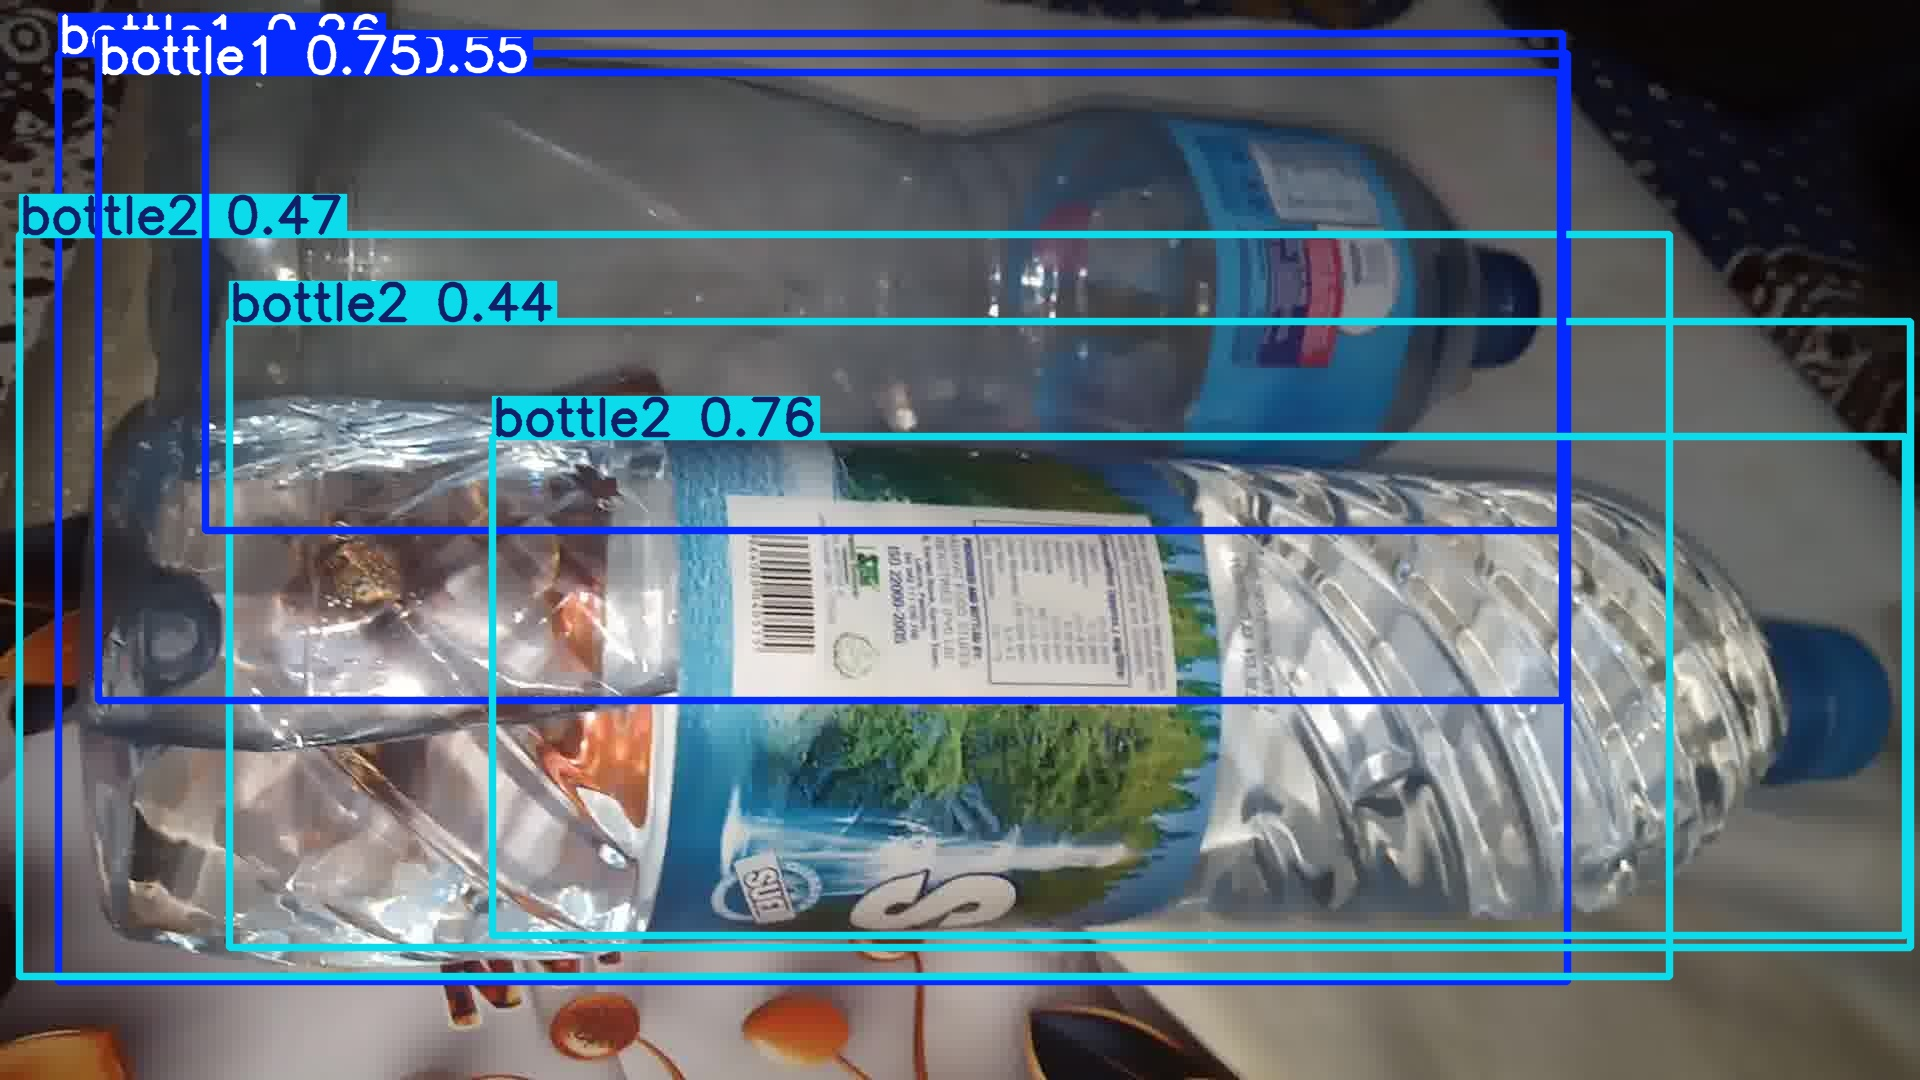

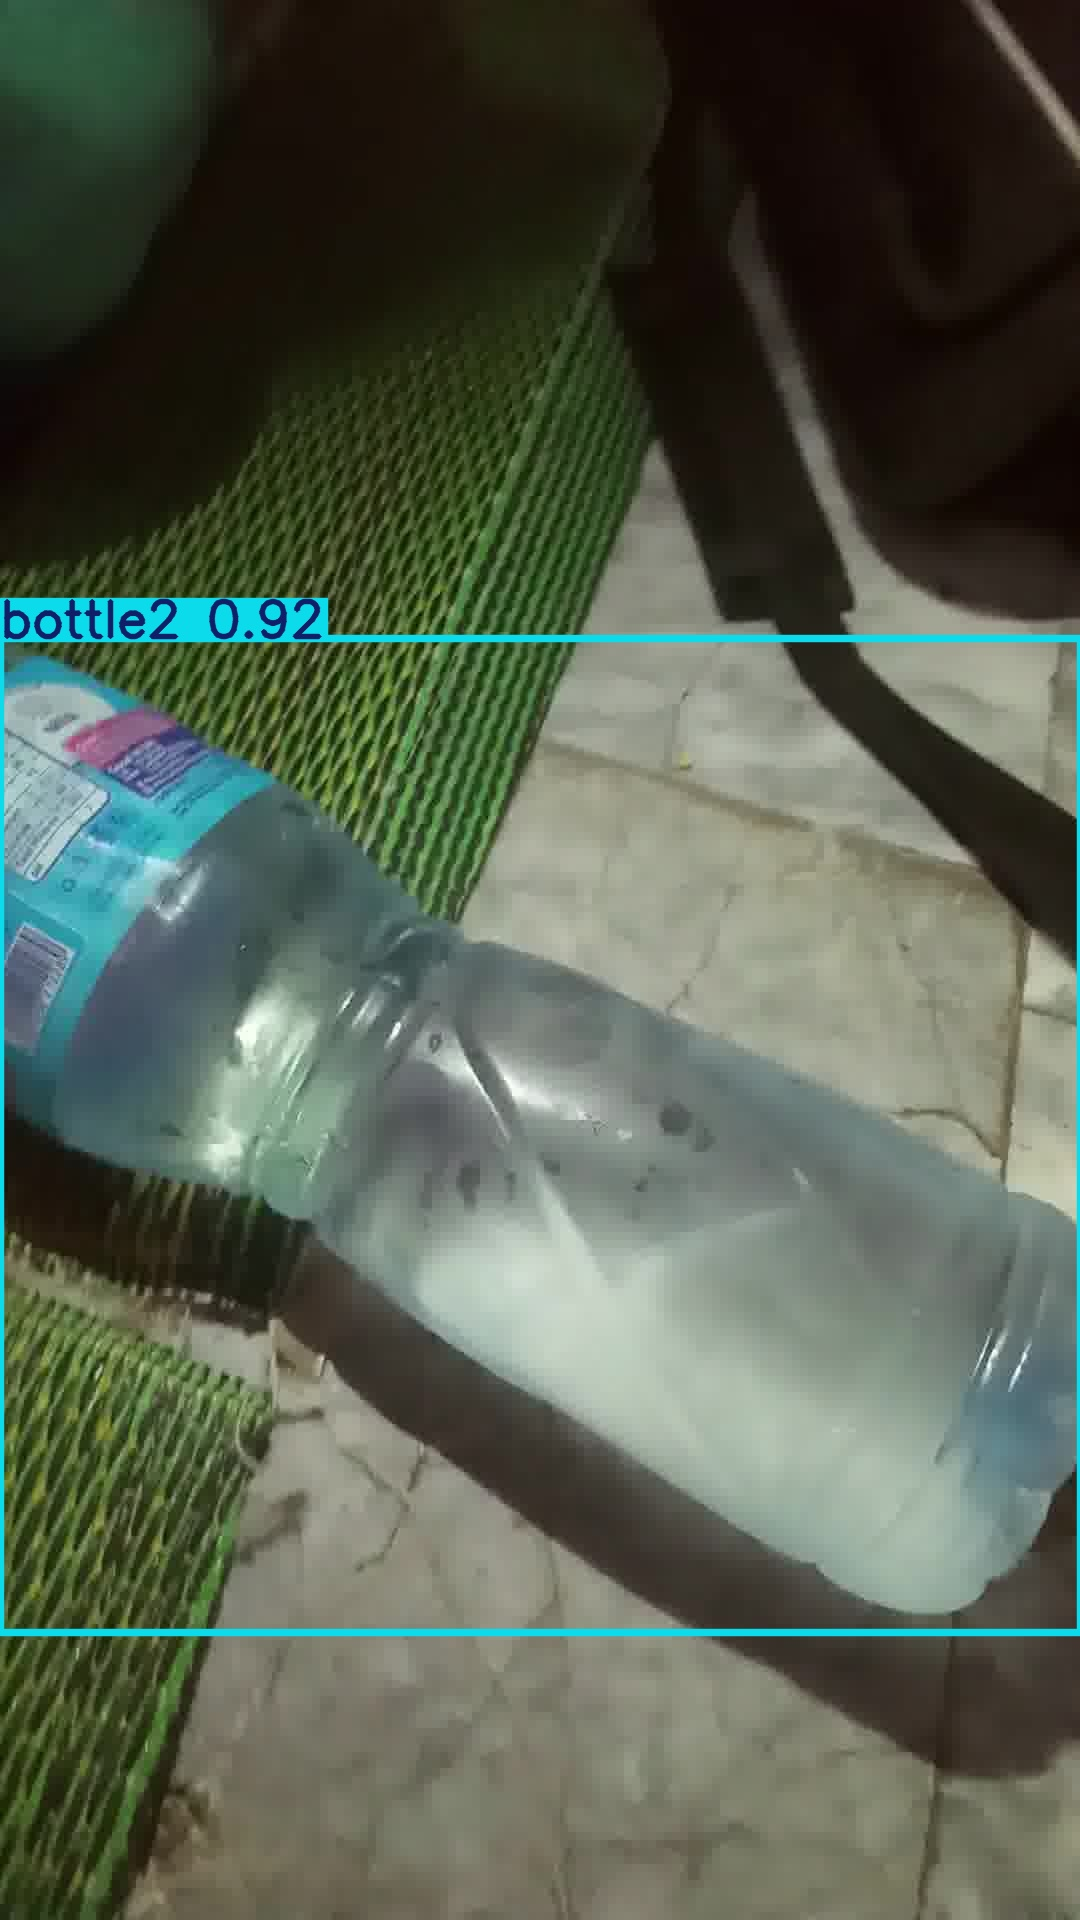

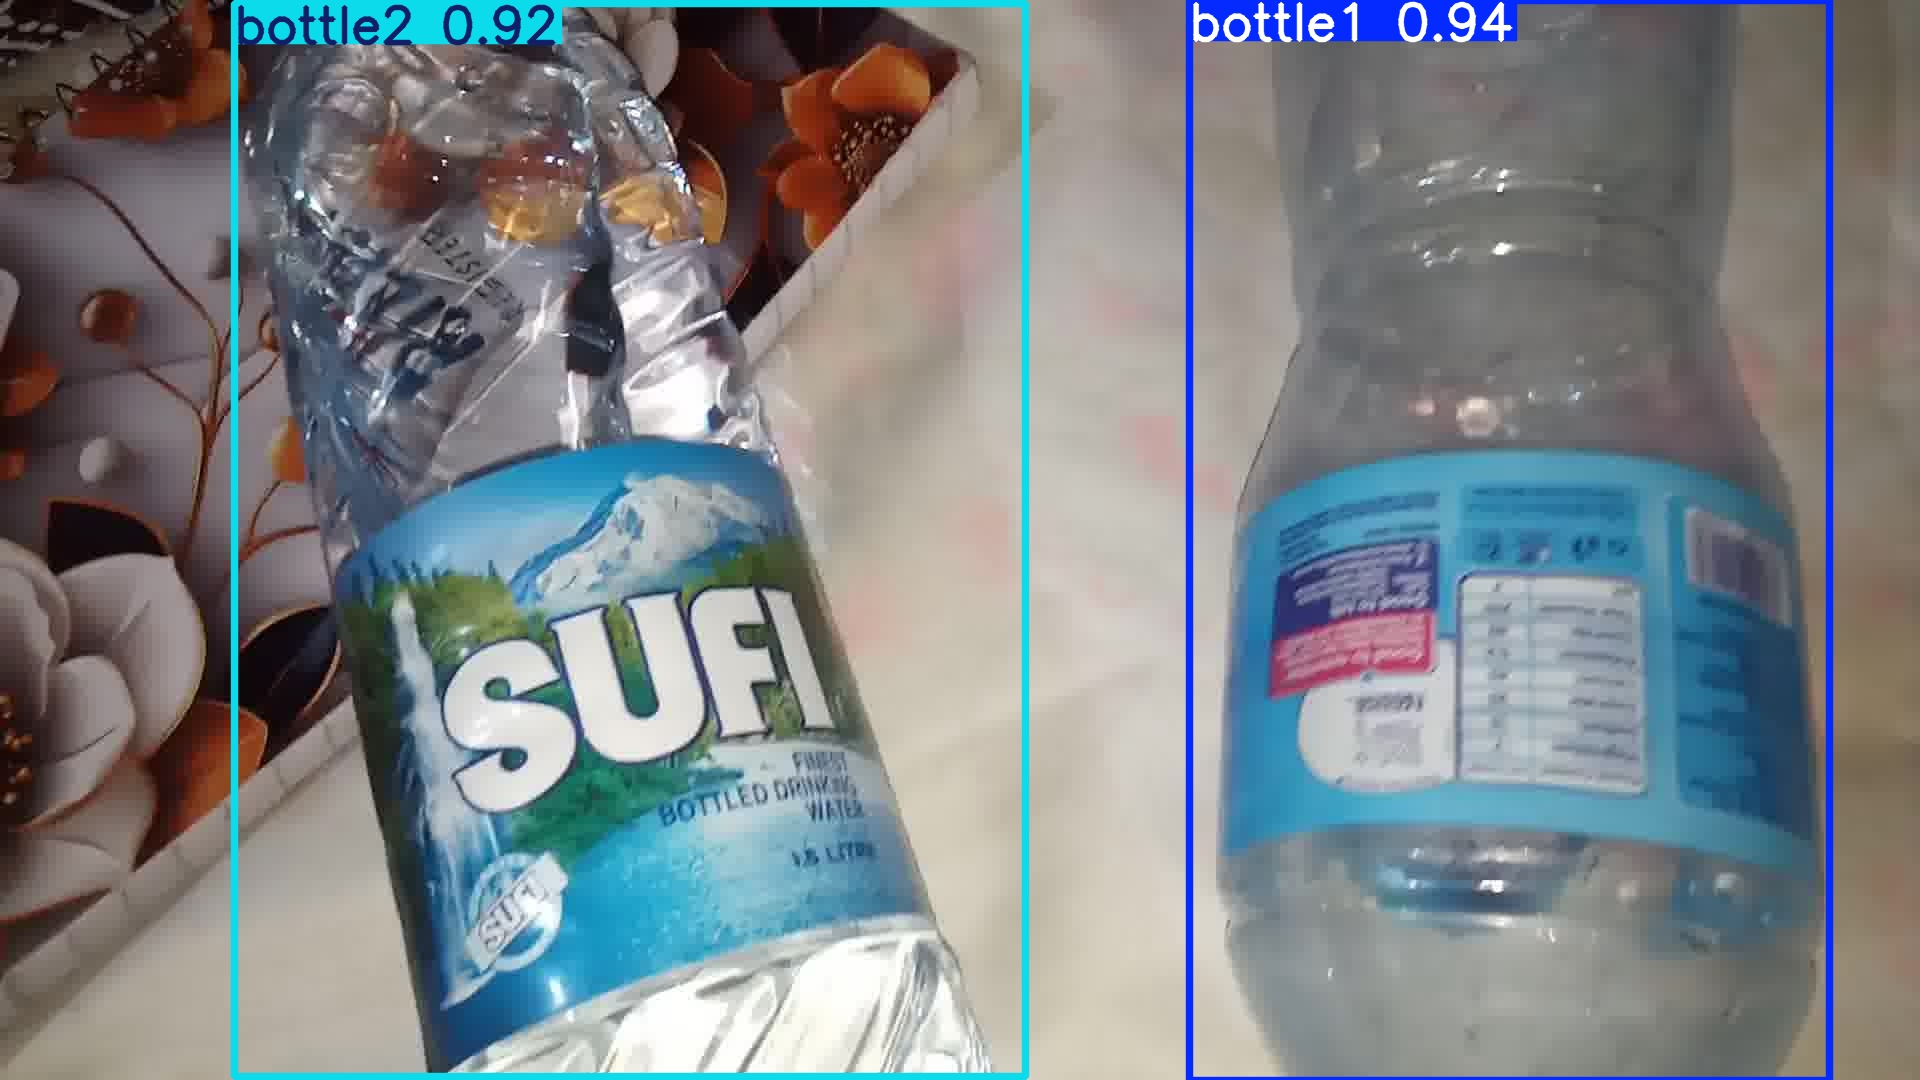

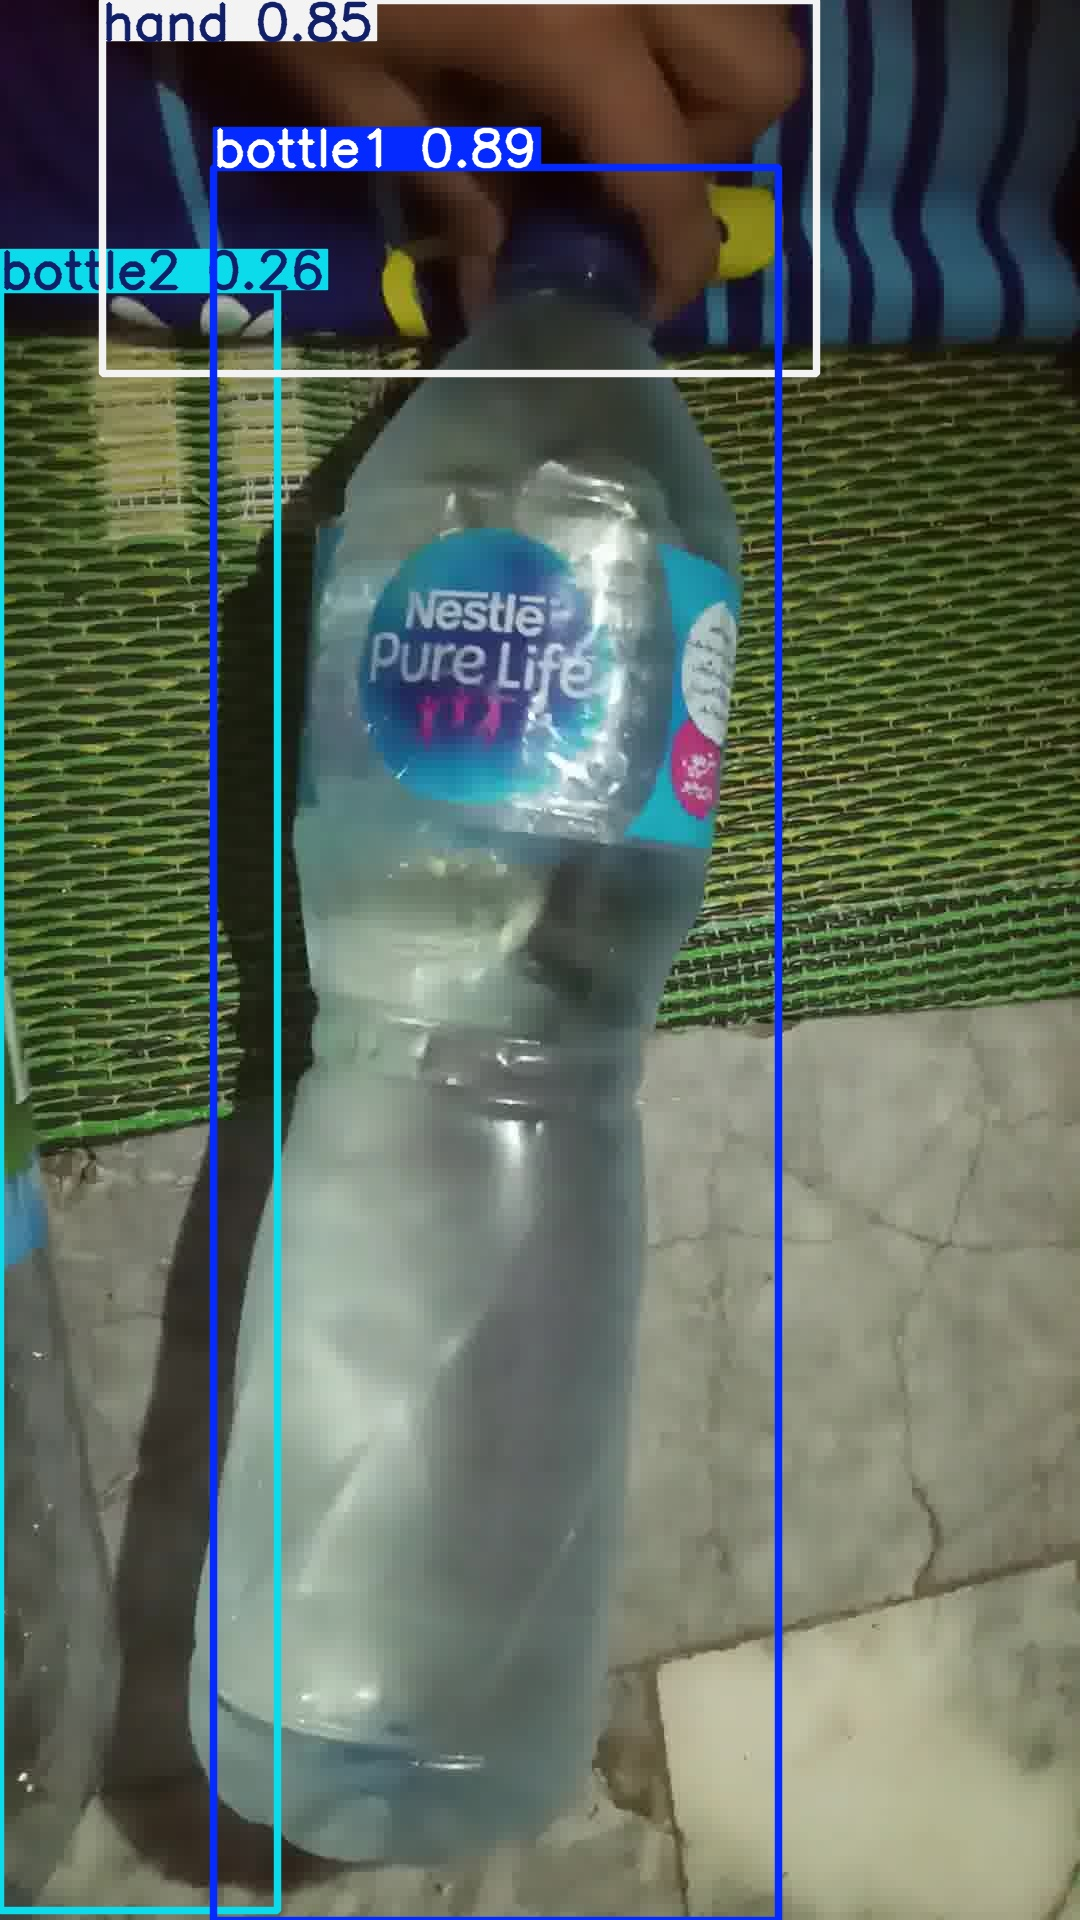

In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


The model is expected to draw a box around each object of interest in every image. If the object detection results aren't satisfactory, consider the following tips:
* Review your dataset for labeling mistakes or inconsistent annotations.
* Train the model for more epochs to improve performance.
* Try using a larger model architecture (e.g., yolo11l.pt).
* Expand your training dataset by adding more images.

You can also test the model on video files or additional images by uploading them to this notebook and using the !yolo detect predict command. Just set the source parameter to the path of the video, image, or folder of images. The output will be saved in runs/detect/predict.

## 🚀📦➡️💻 Step 7: Deploy model
Now that your custom model is trained, it's ready for download and deployment in your application! YOLO models are compatible with a wide range of hardware—from PCs and embedded devices to smartphones. Ultralytics simplifies the process of converting YOLO models to different formats (such as TFLite, ONNX, and more), making it easy to deploy across various platforms.

## 7.1 Download YOLO Model

In [ ]:

!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

from google.colab import files
files.download('/content/my_model.zip')


/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/confusion_matrix.png (deflated 35%)
  adding: train/args.yaml (deflated 53%)
  adding: train/results.png (deflated 6%)
  adding: train/F1_curve.png (deflated 11%)
  adding: train/val_batch0_pred.jpg (deflated 16%)
  adding: train/confusion_matrix_normalized.png (deflated 30%)
  adding: train/train_batch2.jpg (deflated 6%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/best.pt (deflated 8%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/train_batch0.jpg (deflated 7%)
  adding: train/labels_correlogram.jpg (deflated 43%)
  adding: train/train_batch401.jpg (deflated 16%)
  adding: train/R_curve.png (deflated 13%)
  adding: train/train_batch1.jpg (deflated 6%)
  adding: train/train_batch400.jpg (deflated 12%)
  adding: train/results.csv (deflated 61%)
  adding: train/labels.jpg (deflated 21%)
  adding: train/PR_curve.png (deflated 23%)
  adding: train/val_batch0_l

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 🖥️ Step 8: Deploy on Local PC

Now, we’ll use the downloaded model and run it on a local device. This section offers step-by-step guidance on how to deploy YOLO models across different types of hardware.

A Github basic Python script, `yolo_detect.py`, that shows how to load a model, run inference on an image source, parse the inference results, and display boxes around each detected class in the image. The [script](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/yolo_detect.py) gives an example of how to work with Ultralytics YOLO models in Python, and it can be used as a starting point for more advanced applications.

### 8.1 Deploy on PC (Windows, Linux, or macOS)
The simplest way to run Ultralytics models on a PC is through Anaconda. It creates a virtual Python environment and makes installing Ultralytics and PyTorch straightforward. Anaconda also handles the installation of CUDA and cuDNN, enabling faster model inference using your NVIDIA GPU.


**1. Download and Install Anaconda**

Go to the Anaconda download page and then download the package for your OS. When it's finished downloading, run the installer and click through the installation steps. You can use the default options for installation.

**2. Set up virtual environment**

Once it's installed, run Anaconda Prompt from the Start Bar. (If you're on macOS or Linux, just open a command terminal).

Issue the following commands to create a new Python environment and activate it:

```
conda create --name yolo-env1 python=3.12 -y
conda activate yolo-env1
```
Install Ultralytics (which also installs import libraries like OpenCV-Python, Numpy, and PyTorch) by issuing the following command:
```
pip install ultralytics
```
If you have an NVIDIA GPU, you can install the GPU-enabled version of PyTorch by issuing the following command:

```
pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
```
# OR

vist this site https://pytorch.org/get-started/locally/

On this page, you’ll see a section called "Start Locally."

This tool helps you generate the correct install command for PyTorch based on your system and preferences. PyTorch is available in two main builds:

* Stable: The most tested and officially supported version. Recommended for most users.

* Preview: The latest nightly build with the newest features, but not fully tested.

Select your configuration using the dropdown menus:

PyTorch Build: Stable or Preview

Your OS: **Windows** / Linux / macOS

Package: **Pip** or Conda

Language: **Python**

Compute Platform: Choose CPU or your CUDA version such as CUDA 12.6 etc

Once you make your selections, the website will generate a custom install command.

Copy and paste the generated command into your terminal or Anaconda Prompt (after activating your virtual environment).

**3. Extract downloaded model**
Take the `my_model(1).zip` file you downloaded in Step 7.1 and unzip it to a folder(yolo_proj) on your PC. In the Anaconda Prompt terminal, move into the unzipped folder using:

```
cd path/to/folder
```
**4. Download and run yolo_detect.py**

Download the `yolo_detect.py` script into the `my_model` folder using:

```
curl -o yolo_detect.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/yolo_detect.py
```
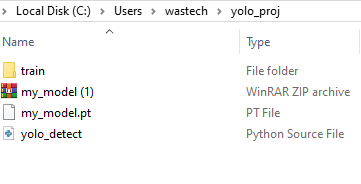

example folder yolo_proj having the zip file and their extracted files with yolo_detect.py file

We're ready to run the script. To run inference with a yolov8s model on a USB camera at 1280x720 resolution, issue:

```
python yolo_detect.py --model my_model.pt --source usb0 --resolution 1280x720
```


## ✅ Conclusion & Future Improvements

You now have a fully functional object detection model trained to detect two types of water bottles. This workflow can be extended to detect other objects by labeling more images and adjusting class names.

### 🔮 Future Improvements:
- Expand dataset with more lighting conditions and angles.
- Fine-tune YOLO model size (`yolov8s`, `m`, `l`) for accuracy or speed.
- Deploy on mobile apps using ONNX or TensorFlow Lite.
- Use with Raspberry Pi and edge devices for embedded detection.
- Connect it with a Streamlit or Flask app for live web-based detection.

This model is a solid foundation for computer vision tasks in retail, robotics, inventory management, and more.